# 스프린트 미션 06

## 1. 미션 소개

- 이번 미션의 목표는 X-Ray 사진을 입력으로 받아 폐렴 여부를 구분하는 분류 (Classification) 모델을 만드는 것입니다
-  아래 데이터셋을 활용하여 다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험해보고, 모델의 성능을 평가해 보세요.

1.   분석 과정과 결과:
데이터 로드, 전처리, 모델 학습, 예측, 성능 평가 등의 모든 과정을 포함해야 합니다.
사전 학습된 모델을 활용한 Transfer Learning을 적용해 보세요.
Fine-Tuning을 적용해 보세요. Frozen 모델, Partial Fine-Tuning, Full Fine-Tuning을 비교하며 실험을 진행해 봅시다.
모델별 성능 비교, 분석 결과를 코드와 함께 정리해 주세요.

2.   마크다운을 활용한 설명
코드의 각 단계에서 어떤 작업을 수행하는지, 어떤 의도를 가지고 접근했는지 명확히 표현할 수 있도록 마크다운을 적극 활용해 주세요.
코드와 실행 결과를 설명하는 문구를 추가하여, 전체 코드의 흐름을 이해할 수 있도록 작성해 주세요. 보고서를 따로 작성하지 않으므로, 노트북 파일 내에 모든 설명이 잘 드러나야 합니다.

3.   모델 성능 평가 및 제출
평가 지표(Accuracy, Precision, Recall, F1-score 등)를 활용해 모델 성능을 분석하고 비교해 보세요.
제공된 데이터셋의 테스트 파일을 사용하여 모델을 테스트해 보세요.
모델별 성능 평가 결과를 포함한 노트북 파일을 제출하세요.

## 1-1 데이터 소개
train  
NORMAL: 폐렴 없는 정상 X-ray 사진
PNEUMONIA: 폐렴이 있는 X-ray 사진
→ 훈련(training) 데이터로 사용해서 모델이 '정상'과 '폐렴'을 구분하도록 학습시킴.

val (validation)  
NORMAL, PNEUMONIA

test  
NORMAL, PNEUMONIA
→ 최종 성능 평가(test) 에 사용. (모델이 훈련이나 검증에 한 번도 본 적 없는 데이터)

## 2. 사전 조사

## 2-1 폐렴 X-ray 소견

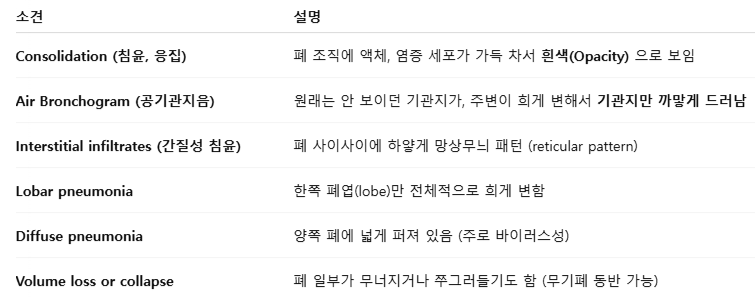

## 2-2 주요 쟁점

## 폐렴을 판독할 때 폐 주변(쇄골, 갈비뼈 등)도 보는 것이 도움이 될까?

-> **네, 실제 사람(의사) 기준으로는 폐만 보는 것보다 주변 구조물(쇄골, 갈비뼈 등)도 포함되어 있는 것이 실제 진단에서는 도움이 됩니다.**

- 폐렴의 특징은 단순히 폐 안의 문제(침윤, consolidation)만 보는 것이 아니라, 폐의 모양, 크기, 위치 변화도 진단 단서가 되기 때문
- 폐가 부풀어 오르면 (공기 저류 등) 갈비뼈 간격이 넓어질 수 있습니다.
- 심한 감염이 있으면 기관이 밀리거나(mediastinal shift) 흉막 삼출(pleural effusion)이 생겨 폐 바깥쪽 윤곽 변화가 보입니다.
- 즉, 폐+주변 구조를 함께 관찰하면 폐렴을 더 정확하게 진단할 수 있습니다.


-> **하지만 모델 학습은 다르다.**  
- 모델은 주변 구조를 잘못 학습하면 오히려 혼란을 겪을 수 있습니다.  
- 모델은 주변 노이즈에 쉽게 휘둘릴 수 있음
- 폐 영역을 중심으로 학습 후 성능 확인

📌 그래서 실전에서는?

초기에는 폐 영역 중심으로 크롭해서 학습 -> 이후 성능 한계가 보이면, 전체 X-ray로 다시 학습해보고 주변 구조까지 고려하는 모델로 확장


**그럼 이미지에서 폐를 관찰해서 부분을 가져오는 것을 어떻게 해야 하나?**

1. 고정 crop

2. 정교한 방법: "Lung Segmentation" (폐 분할)

U-Net 같은 segmentation 모델을 이용해 폐만 정확히 마스크(mask) 씌워서 자릅니다.
좀 더 정확한 폐 형태를 얻을 수 있습니다.

---

-> 우선 고정 crop 방법 사용

## 3. 데이터 로드

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import TensorDataset

In [ ]:
img = Image.open('workspace/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

In [ ]:
# 원본이미지는 흑백

print(img.mode)

L


In [ ]:
# GPU 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import os

# 현재 작업 디렉토리 확인
print("현재 디렉토리:", os.getcwd())

# 현재 디렉토리 안 파일 목록 확인
print("\n현재 디렉토리 파일 목록:")
print(os.listdir())

현재 디렉토리: /

현재 디렉토리 파일 목록:
['bin', 'boot', 'dev', 'etc', 'home', 'lib', 'lib64', 'media', 'mnt', 'opt', 'proc', 'root', 'run', 'sbin', 'srv', 'sys', 'tmp', 'usr', 'var', '.launch', 'workspace', '.first_boot_complete', 'provisioning.sh', '.provisioning_complete', '.ipynb_checkpoints', 'venv', '스프린트 미션 06_vast(0508).ipynb', '.dockerenv', 'bin.usr-is-merged', 'lib.usr-is-merged', 'sbin.usr-is-merged', 'NGC-DL-CONTAINER-LICENSE']


In [ ]:
# 이미지 데이터 압축파일 해제

import zipfile

zip_path = "/workspace/archive.zip"
extract_path = "/workspace"

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료!")

압축 해제 완료!


In [ ]:
# 파일 경로

train_pneu_dir = "/workspace/chest_xray/train/PNEUMONIA"
train_normal_dir = "/workspace/chest_xray/train/NORMAL"

test_pneu_dir = "/workspace/chest_xray/test/PNEUMONIA"
test_normal_dir = "/workspace/chest_xray/test/NORMAL"

val_pneu_dir = "/workspace/chest_xray/val/PNEUMONIA"
val_normal_dir = "/workspace/chest_xray/val/NORMAL"


# 지정된 폴더에서 JPEG 형식의 흑백 이미지를 불러와 리스트로 반환 / 실패한 파일은 건너뜀

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(".jpeg"):  # 대소문자 무시하고 jpeg만
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: {img_path} is not a valid image file.")
                continue  # 읽기 실패한 파일은 건너뜀
            images.append(img)
    return images

# 이미지 불러오기 (array 형태)

train_pneu_img = load_images_from_folder(train_pneu_dir)
train_normal_img = load_images_from_folder(train_normal_dir)

test_pneu_img =load_images_from_folder(test_pneu_dir)
test_normal_img =load_images_from_folder(test_normal_dir)

val_pneu_img = load_images_from_folder(val_pneu_dir)
val_normal_img =load_images_from_folder(val_normal_dir)

# 데이터셋 내 이미지 수 확인
print(f"train_pneu_img: {len(train_pneu_img)}")
print(f"train_normal_img: {len(train_normal_img)}")

print(f"test_pneu_img: {len(test_pneu_img)}")
print(f"test_normal_img: {len(test_normal_img)}")

print(f"val_pneu_img: {len(val_pneu_img)}")
print(f"val_normal_img: {len(val_normal_img)}")

train_pneu_img: 3875
train_normal_img: 1341
test_pneu_img: 390
test_normal_img: 234
val_pneu_img: 8
val_normal_img: 8


In [ ]:
# train / test / val 데이터의 PNEUMONIA 이미지와 NORMAL 이미지를 합치고 라벨링 ( 폐렴 : 1 , 정상 : 0)

train_pneu_labels = [1] * len(train_pneu_img)
train_normal_labels = [0] * len(train_normal_img)

train_imgs = train_pneu_img + train_normal_img
train_labels = train_pneu_labels + train_normal_labels

test_pneu_labels = [1] * len(test_pneu_img)
test_normal_labels = [0] * len(test_normal_img)

test_imgs = test_pneu_img + test_normal_img
test_labels = test_pneu_labels + test_normal_labels

val_pneu_labels = [1] * len(val_pneu_img)
val_normal_labels = [0] * len(val_normal_img)

val_imgs = val_pneu_img + val_normal_img
val_labels = val_pneu_labels + val_normal_labels

# 4. 전처리

## 4-1 이미지 크기 확인

In [ ]:
# 각 데이터셋의 이미지 크기 추출
train_imgs_sizes = [img.shape[:2] for img in train_imgs]  # train 이미지의 크기 (height, width)
test_imgs_sizes = [img.shape[:2] for img in test_imgs]  # test 이미지의 크기 (height, width)
val_imgs_sizes = [img.shape[:2] for img in val_imgs]  # val 이미지의 크기 (height, width)

# 유니크한 이미지 크기 계산
train_imgs_unique_sizes = np.unique(train_imgs_sizes, axis=0)  # train 이미지의 유니크 크기
test_imgs_unique_sizes = np.unique(test_imgs_sizes, axis=0)  # test 이미지의 유니크 크기
val_imgs_unique_sizes = np.unique(val_imgs_sizes, axis=0)  # val 이미지의 유니크 크기

# 결과 출력
print("Unique sizes in train - PNEUMONIA:\n", train_imgs_unique_sizes)
print("Unique sizes in test - PNEUMONIA:\n", test_imgs_unique_sizes)
print("Unique sizes in val - PNEUMONIA:\n", val_imgs_unique_sizes)

Unique sizes in train - PNEUMONIA:
 [[ 127  384]
 [ 132  446]
 [ 138  400]
 ...
 [2625 2694]
 [2628 2619]
 [2663 2373]]
Unique sizes in val - PNEUMONIA:
 [[ 592  968]
 [ 656 1016]
 [ 664 1152]
 [ 712 1072]
 [ 864 1256]
 [ 928 1288]
 [ 944 1416]
 [ 952 1192]
 [1040 1272]
 [1104 1240]
 [1104 1328]
 [1128 1664]
 [1225 1632]
 [1302 1564]
 [1416 1736]
 [1416 1776]]


- 이미지 크기가 다양해서 전처리를 해야하는데 그냥 resize를 하면 모든 데이터가 같은 크기에 맞춰짐으로써 이미지가 눌리거나 늘어날수 있으므로
- 이미지를 W,H 중 긴쪽에 맞춰서 padding을 하고 , 전체 데이터 이미지의 평균 길이로 resize 후 불필요한 이미지 잘라내기

In [ ]:
# 이미지의 W , H 중 더 큰값에 맞춰서 검은색으로 padding

class LongestSidePad:
    def __call__(self, img):
        # 텐서 크기 가져오기 (C, H, W 형식)
        _, height, width = img.shape

        target_size = max(height, width)

        # 패딩 계산
        pad_top = (target_size - height) // 2
        pad_bottom = target_size - height - pad_top
        pad_left = (target_size - width) // 2
        pad_right = target_size - width - pad_left

        # 패딩 적용
        # TF = torchvision.transforms.fuctional
        # 검은색 padding 추가

        return TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=0)

In [ ]:
# padding이 된 학습시킬 데이터 이미지의 평균 길이로 resize
# resize 할 크기 계산

total_size = 0

for img in train_imgs:
    height, width = img.shape
    total_size += max(height, width)

print(f"resize 할 크기: {total_size / len(train_imgs) }")

resize 할 크기: 1321.6953604294479


- 32의 배수인 1344로 resize (컴퓨터의 계산 속도 향상을 위해)

In [ ]:
# 이미지내 폐를 제외한 불필요한 이미지를 좌우 / 상하 삭제
# 1344 * 1344 이미지를 1152 * 1152 이미지로 잘라냄

class CustomCrop:
    def __call__(self, img):
        _, h, w = img.shape  # (C, H, W)

        assert h == 1344 and w == 1344, "Input size must be 1344x1344!"

        left = 96
        right = w - 96
        top = 134
        bottom = h - 58

        cropped_img = img[:, top:bottom, left:right]

        return cropped_img

In [ ]:
transform_fn = v2.Compose(
    [
        v2.ToImage(),  # PIL or ndarray → tv_tensors.Image로 변환
        LongestSidePad(),
        v2.Resize((1344,1344)),
        CustomCrop(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

In [ ]:
#  이미지 데이터와 라벨을 받아 PyTorch의 Dataset 형식으로 변환해주는 클래스

class ImgDataset(Dataset):
    def __init__(self, imgs, labels, transforms = None):
        self.imgs = imgs
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]

        if self.transforms:
            img = self.transforms(img)

        return img, label

In [ ]:
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

In [ ]:
# 평균 / 표준편차로 정규화

total_sum = 0
total_squared_sum = 0
total_pixels = 0

for i in range(len(train_dataset)):
    img, _ = train_dataset[i]  # transform 적용된 이미지 (C, H, W)

    total_sum += img.sum()
    total_squared_sum += (img ** 2).sum()
    total_pixels += img.numel()

# 평균 (mean)
mean_pixel_value = total_sum / total_pixels

# 분산 (Var = E[X^2] - E[X]^2)
variance = (total_squared_sum / total_pixels) - mean_pixel_value ** 2
std_pixel_value = variance.sqrt()

print(f"전체 픽셀 평균값: {mean_pixel_value.item():.4f}")
print(f"전체 픽셀 표준편차: {std_pixel_value.item():.4f}")

전체 픽셀 평균값: 0.4427
전체 픽셀 표준편차: 0.2732


In [ ]:
transform_fn = v2.Compose(
    [
        v2.ToImage(),  # PIL or ndarray → tv_tensors.Image로 변환
        LongestSidePad(),
        v2.Resize((1344,1344)),
        CustomCrop(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean=[0.4427], std=[0.2732])
    ]
)

In [ ]:
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

## 4-2 시드 고정

In [ ]:
import random

def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## dataset -> dataloader
batch size= 16

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)

## 4-3 모델 평가에 사용할 지표
**accuracy_score : 정확도**


전체 중에서 정답 맞춘 비율
직관적이지만 데이터 불균형에 약함
대부분 0인 데이터에서 다 0만 예측해도 높은 accuracy가 나올 수 있음



**precision_score : 정밀도**

내가 양성(1) 이라고 예측한 것들 중에서 실제로 맞춘 비율
예측한 것 중 얼마나 정확하게 맞췄는지
오탐(FP)을 줄이는 데 집중
예: "진짜 병 걸린 사람만 골라야 하는 의료 진단"에서 중요

**recall_score : 재현율**


실제 양성(1) 중에서 내가 얼마나 잘 찾아냈는가
놓친 것(FN)을 줄이는 데 집중
예: "실제 스팸 메일을 하나도 놓치지 않아야 하는 스팸 필터"

**f1_score : 조화 평균**


Precision과 Recall 사이의 균형을 잡는 지표
둘 다 중요할 때 사용
한 쪽만 높고 다른 쪽이 낮으면 F1도 낮게 나옴




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 4-4 간단한 모델로 전처리 test

- 입력한 이미지의 크기가 1152 * 1152 로 충분히 크기 때문에, 첫 번째 Conv2d 층에서는 큰 receptive field를 확보하기 위해 커널 크기를 7로 설정하였고, stride를 2로 두어 초반에 Downsampling을 수행합니다.
- 이후 두 번째 Conv2d에서는 커널 크기 3, stride 1, padding 1로 설정하여 feature map 크기를 유지하면서 특징을 추출합니다. 그 후 MaxPool2d(2)를 통해 공간 크기를 절반으로 줄입니다.
- 세 번째 Conv2d 또한 커널 크기 3, stride 1, padding 1을 사용해 크기를 유지하면서 추가적인 특징 추출을 수행합니다.
- 각 Conv2d 층 뒤에는 BatchNorm2d를 적용하여 학습 안정성과 수렴 속도를 개선하고, 비선형성을 주기 위해 ReLU 활성화 함수를 사용합니다.
- 마지막으로 AdaptiveAvgPool2d((1,1))을 사용하여 feature map을 1×1 크기로 평균 풀링하여 고정된 크기의 벡터로 변환합니다. 이후 Flatten을 통해 1차원으로 펼치고, 최종 Linear(64→1) 계층을 통해 이진 분류를 위한 출력값을 생성합니다.

In [ ]:
class Model_1(nn.Module):
        def __init__(self):
            super().__init__()

            self.features = nn.Sequential(
                # input : (1, 1152, 1152)
                nn.Conv2d(1, 32, kernel_size=7, stride = 2, padding = 3),  # -> (32, 576, 576)
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 64, kernel_size = 3, stride =1, padding=1), # -> (64, 576, 576)
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2), # -> (64, 288, 288)

                nn.Conv2d(64, 64, kernel_size = 3, stride =1, padding=1), # -> (64, 228, 228)
                nn.BatchNorm2d(64),
                nn.ReLU(),
            )
            self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((1,1)), # -> (64, 1, 1)
                nn.Flatten(), # -> (64,)
                nn.Linear(64, 1)  # -> (1,)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

In [ ]:
model_1152 = Model_1()
model_1152 = model_1152.to(device)

# 손실 함수
# BCEWithLogitsLoss, 즉 시그모이드와 BCE를 합친 손실 함수 사용 / 이진 분류 문제에 적합하고 수치 안정성이 뛰어남

criterion = nn.BCEWithLogitsLoss()  # 이진 분류
optimizer = optim.Adam(model_1152.parameters(), lr=1e-3)

In [ ]:
# input image size = 1152 * 1152

Epochs = 20
for epoch in range(Epochs):
    model_1152.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_1152(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Acc={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

Epoch 1: Loss=107.9580 | Acc=0.8675 | Precision=0.8860 | Recall=0.9430 | F1=0.9136
Epoch 2: Loss=88.9346 | Acc=0.8852 | Precision=0.9085 | Recall=0.9401 | F1=0.9240
Epoch 3: Loss=86.2878 | Acc=0.8898 | Precision=0.9139 | Recall=0.9401 | F1=0.9269
Epoch 4: Loss=80.1722 | Acc=0.8976 | Precision=0.9219 | Recall=0.9419 | F1=0.9318
Epoch 5: Loss=67.8633 | Acc=0.9193 | Precision=0.9428 | Recall=0.9489 | F1=0.9459
Epoch 6: Loss=72.1313 | Acc=0.9114 | Precision=0.9377 | Recall=0.9435 | F1=0.9406
Epoch 7: Loss=65.6906 | Acc=0.9210 | Precision=0.9506 | Recall=0.9427 | F1=0.9466
Epoch 8: Loss=65.1184 | Acc=0.9183 | Precision=0.9457 | Recall=0.9443 | F1=0.9450
Epoch 9: Loss=62.9194 | Acc=0.9260 | Precision=0.9530 | Recall=0.9471 | F1=0.9500
Epoch 10: Loss=64.8913 | Acc=0.9218 | Precision=0.9487 | Recall=0.9458 | F1=0.9473
Epoch 11: Loss=63.3468 | Acc=0.9202 | Precision=0.9438 | Recall=0.9492 | F1=0.9465
Epoch 12: Loss=54.5830 | Acc=0.9367 | Precision=0.9593 | Recall=0.9554 | F1=0.9573
Epoch 13: Lo

In [ ]:
# 모델 성능을 평가하는 함수

def evaluate(model, dataloader, criterion, device):
    model.eval()  # 평가 모드 전환
    correct = 0
    total = 0
    loss_sum = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device)
            label = label.to(device)

            output = model(img)
            loss = criterion(output, label.float().unsqueeze(1))
            loss_sum += loss.item()

            pred = (torch.sigmoid(output) > 0.5).int().squeeze()

            # 누적 정확도 계산용
            correct += (pred == label).sum().item()
            total += label.size(0)

            # precision/recall/F1 계산용
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # 지표 계산
    accuracy = correct / total
    avg_loss = loss_sum / len(dataloader)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Loss     : {avg_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    #return accuracy, avg_loss, precision, recall, f1

In [ ]:
evaluate(model_1152, test_dataloader, criterion, device)

Accuracy : 0.7500
Loss     : 0.9353
Precision: 0.7167
Recall   : 0.9923
F1-score : 0.8323


(0.75,
 0.935336674635227,
 0.7166666666666667,
 0.9923076923076923,
 0.832258064516129)

- Recall이 매우 높고 Precision은  낮음 → 모델이 놓치는 건 거의 없지만, 거짓 양성(False Positive) 예측이 많음
- 모델이 거의 폐렴이라고 예측을 함 -> 정상도 폐렴으로 보는 경향
- 이미지의 사이즈가 크니까 학습하는데 시간이 오래걸림
- 학습 데이터로의 정확도는 꾸준히 올라갔지만 테스트 데이터의 정확도는 낮게 나옴
- 과적합 가능성 있음

## 4-5 학습하는데 시간이 너무 오래 걸려서 이미지 size 줄이기
## size 512 ( 600 -> 512 )

In [ ]:
# 600 -> 512
class CustomCrop:
    def __call__(self, img):
        _, h, w = img.shape  # (C, H, W)

        assert h == 600 and w == 600, "Input size must be 600x600!"

        left = 44
        right = w - 44
        top = 55
        bottom = h - 33

        cropped_img = img[:, top:bottom, left:right]

        return cropped_img

In [ ]:
transform_fn = v2.Compose(
    [
        v2.ToImage(),  # PIL or ndarray → tv_tensors.Image로 변환
        LongestSidePad(),
        v2.Resize((600,600)),
        CustomCrop(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

In [ ]:
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

In [ ]:
total_sum = 0
total_squared_sum = 0
total_pixels = 0

for i in range(len(train_dataset)):
    img, _ = train_dataset[i]  # transform 적용된 이미지 (C, H, W)

    total_sum += img.sum()
    total_squared_sum += (img ** 2).sum()
    total_pixels += img.numel()

# 평균 (mean)
mean_pixel_value = total_sum / total_pixels

# 분산 (Var = E[X^2] - E[X]^2)
variance = (total_squared_sum / total_pixels) - mean_pixel_value ** 2
std_pixel_value = variance.sqrt()

print(f"전체 픽셀 평균값: {mean_pixel_value.item():.4f}")
print(f"전체 픽셀 표준편차: {std_pixel_value.item():.4f}")

전체 픽셀 평균값: 0.4461
전체 픽셀 표준편차: 0.2711


In [ ]:
transform_fn = v2.Compose(
    [
        v2.ToImage(),  # PIL or ndarray → tv_tensors.Image로 변환
        LongestSidePad(),
        v2.Resize((600,600)),
        CustomCrop(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean=[0.4461], std=[0.2711])
    ]
)

In [ ]:
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)

In [ ]:
class Model_2(nn.Module):
        def __init__(self):
            super().__init__()

            self.features = nn.Sequential(
                # input : (1, 512, 512)
                nn.Conv2d(1, 32, kernel_size=5, stride = 2, padding = 2),  # -> (32, 256, 256)
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 64, kernel_size = 3, stride =1, padding=1), # -> (64, 256, 256)
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2), # -> (64, 128, 128)

                nn.Conv2d(64, 64, kernel_size = 3, stride =1, padding=1), # -> (64, 128, 128)
                nn.BatchNorm2d(64),
                nn.ReLU(),
            )
            self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((1,1)),
                nn.Flatten(),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

In [ ]:
model_512 = Model_2()
model_512 = model_512.to(device)

# 손실 함수
criterion = nn.BCEWithLogitsLoss()  # 이진 분류
optimizer = optim.Adam(model_512.parameters(), lr=1e-3)

In [ ]:
Epochs = 20
# input image size = 512 * 512
for epoch in range(Epochs):
    model_512.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_512(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Acc={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

Epoch 1: Loss=123.2453 | Acc=0.8457 | Precision=0.8639 | Recall=0.9404 | F1=0.9005
Epoch 2: Loss=89.4017 | Acc=0.8884 | Precision=0.9101 | Recall=0.9430 | F1=0.9262
Epoch 3: Loss=81.7630 | Acc=0.8953 | Precision=0.9221 | Recall=0.9383 | F1=0.9302
Epoch 4: Loss=80.4709 | Acc=0.8982 | Precision=0.9254 | Recall=0.9386 | F1=0.9320
Epoch 5: Loss=77.0195 | Acc=0.9062 | Precision=0.9301 | Recall=0.9448 | F1=0.9374
Epoch 6: Loss=73.8472 | Acc=0.9043 | Precision=0.9308 | Recall=0.9412 | F1=0.9360
Epoch 7: Loss=74.8719 | Acc=0.9064 | Precision=0.9357 | Recall=0.9386 | F1=0.9371
Epoch 8: Loss=74.0982 | Acc=0.9070 | Precision=0.9317 | Recall=0.9440 | F1=0.9378
Epoch 9: Loss=74.0411 | Acc=0.9064 | Precision=0.9346 | Recall=0.9399 | F1=0.9372
Epoch 10: Loss=70.6346 | Acc=0.9109 | Precision=0.9363 | Recall=0.9443 | F1=0.9403
Epoch 11: Loss=71.4045 | Acc=0.9153 | Precision=0.9396 | Recall=0.9468 | F1=0.9432
Epoch 12: Loss=69.3250 | Acc=0.9128 | Precision=0.9376 | Recall=0.9455 | F1=0.9415
Epoch 13: Lo

In [ ]:
evaluate(model_512, test_dataloader, criterion, device)

Accuracy : 0.7869
Loss     : 0.6045
Precision: 0.7617
Recall   : 0.9590
F1-score : 0.8490


(0.7868589743589743,
 0.6044674895894833,
 0.7617107942973523,
 0.958974358974359,
 0.8490351872871736)

- 정확도와 F1-Score가 올랐고 재현율이 떨어졌음 / 모델학습시간은 조금더 빨라졌지만 여전히 학습하는데 시간이 많이 필요함

# size 224 ( 256 -> 224)

In [ ]:
# 256 _> 224

class CustomCrop:
    def __call__(self, img):
        _, h, w = img.shape  # (C, H, W)

        assert h == 256 and w == 256, "Input size must be 256x256!"

        left = 16
        right = w - 16
        top = 22
        bottom = h - 10

        cropped_img = img[:, top:bottom, left:right]

        return cropped_img

In [ ]:
transform_fn = v2.Compose(
    [
        v2.ToImage(),  # PIL or ndarray → tv_tensors.Image로 변환
        LongestSidePad(),
        v2.Resize((256,256)),
        CustomCrop(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean=[0.4300], std=[0.2761])
    ]
)

In [ ]:
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)

In [ ]:
class Model_3(nn.Module):
        def __init__(self):
            super().__init__()

            self.features = nn.Sequential(
                # input : (1, 224, 224)
                nn.Conv2d(1, 32, kernel_size=3, stride = 1, padding = 1),  # -> (32, 224, 224)
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 64, kernel_size = 3, stride =1, padding=1), # -> (64, 224, 224)
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2), # -> (64, 128, 128)

                nn.Conv2d(64, 64, kernel_size = 3, stride =1, padding=1), # -> (64, 128, 128)
                nn.BatchNorm2d(64),
                nn.ReLU(),
            )
            self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((1,1)),
                nn.Flatten(),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

In [ ]:
# 모델 선언
model_224 = Model_3()

# 디바이스 설정 (GPU 사용 가능하면 GPU로)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_224 = model_224.to(device)

# 손실 함수, 최적화기
criterion = nn.BCEWithLogitsLoss()  # 이진 분류
optimizer = optim.Adam(model_224.parameters(), lr=1e-3)

In [ ]:
Epochs = 20
# input image size = 224 * 224
for epoch in range(Epochs):
    model_224.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_224(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Acc={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

Epoch 1: Loss=119.3130 | Acc=0.8443 | Precision=0.8615 | Recall=0.9419 | F1=0.8999
Epoch 2: Loss=88.8473 | Acc=0.8900 | Precision=0.9119 | Recall=0.9430 | F1=0.9272
Epoch 3: Loss=79.5759 | Acc=0.8984 | Precision=0.9225 | Recall=0.9425 | F1=0.9323
Epoch 4: Loss=78.5688 | Acc=0.8990 | Precision=0.9270 | Recall=0.9378 | F1=0.9324
Epoch 5: Loss=74.8380 | Acc=0.9059 | Precision=0.9286 | Recall=0.9461 | F1=0.9372
Epoch 6: Loss=75.0523 | Acc=0.9039 | Precision=0.9330 | Recall=0.9381 | F1=0.9355
Epoch 7: Loss=70.1716 | Acc=0.9139 | Precision=0.9392 | Recall=0.9453 | F1=0.9423
Epoch 8: Loss=66.6852 | Acc=0.9166 | Precision=0.9422 | Recall=0.9458 | F1=0.9440
Epoch 9: Loss=70.3782 | Acc=0.9116 | Precision=0.9368 | Recall=0.9448 | F1=0.9408
Epoch 10: Loss=66.7404 | Acc=0.9187 | Precision=0.9437 | Recall=0.9471 | F1=0.9454
Epoch 11: Loss=65.9923 | Acc=0.9174 | Precision=0.9429 | Recall=0.9461 | F1=0.9445
Epoch 12: Loss=66.5552 | Acc=0.9202 | Precision=0.9449 | Recall=0.9479 | F1=0.9464
Epoch 13: Lo

In [ ]:
evaluate(model_224, test_dataloader, criterion, device)

Accuracy : 0.8045
Loss     : 0.4925
Precision: 0.7724
Recall   : 0.9744
F1-score : 0.8617


(0.8044871794871795,
 0.49251995207025456,
 0.7723577235772358,
 0.9743589743589743,
 0.8616780045351474)

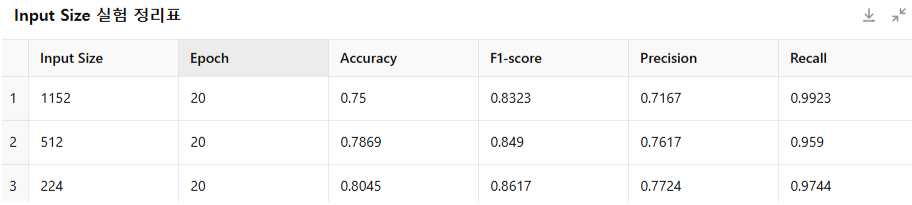

- 어차피 전이학습을 해야하는데 모델을 너무 복잡하게 만들어서 input_size별 결과를 비교하는데 시간이 너무 오래걸림
- input size가 작을수록 Accuracy와 F1-score은 올라가고 실험에 걸리는 시간은 줄어들었음
- epoch을 더 늘려보지 못한 것에 대한 아쉬움이 있음
- 사이즈 224가 학습 속도면에서 우월하며 test 데이터의 정확도와 F1-score가 가장 높았음
- 의학용 데이터라서 최대한 이미지 원본 크기를 유지하면서 모델링에 활용을 하는게 좋지 않을까 하는 생각을 했었는데 물론 20에폭밖에 돌려보진 못했지만
- 생각보다 속도는 매우 느렸고 성능은 별로였음

# 4-6 크롭이 잘된건지 비교

In [ ]:
# 불필요한 부분을 잘라내지 않고 / 바로 224 * 224로 resize

transform_resize_only = v2.Compose([
    v2.ToImage(),
    LongestSidePad(),
    v2.Resize((224,224)),  # 바로 224로 resize
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.4300], std=[0.2761])
])

In [ ]:
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_resize_only)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_resize_only)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_resize_only)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)

model_resize_only = Model_3()

# 디바이스 설정 (GPU 사용 가능하면 GPU로)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resize_only = model_resize_only.to(device)

# 손실 함수, 최적화기
criterion = nn.BCEWithLogitsLoss()  # 이진 분류
optimizer = optim.Adam(model_resize_only.parameters(), lr=1e-3)

Epochs = 20
# input image size = 224 * 224
for epoch in range(Epochs):
    model_resize_only.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_resize_only(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Acc={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

Epoch 1: Loss=129.9510 | Acc=0.8229 | Precision=0.8283 | Recall=0.9608 | F1=0.8896
Epoch 2: Loss=92.1407 | Acc=0.8846 | Precision=0.9030 | Recall=0.9463 | F1=0.9241
Epoch 3: Loss=82.5878 | Acc=0.8957 | Precision=0.9179 | Recall=0.9440 | F1=0.9308
Epoch 4: Loss=76.8201 | Acc=0.8999 | Precision=0.9224 | Recall=0.9448 | F1=0.9335
Epoch 5: Loss=75.0657 | Acc=0.9038 | Precision=0.9275 | Recall=0.9443 | F1=0.9358
Epoch 6: Loss=70.7585 | Acc=0.9128 | Precision=0.9362 | Recall=0.9471 | F1=0.9416
Epoch 7: Loss=72.6461 | Acc=0.9087 | Precision=0.9301 | Recall=0.9484 | F1=0.9392
Epoch 8: Loss=68.5106 | Acc=0.9155 | Precision=0.9403 | Recall=0.9463 | F1=0.9433
Epoch 9: Loss=69.6745 | Acc=0.9101 | Precision=0.9347 | Recall=0.9450 | F1=0.9398
Epoch 10: Loss=68.0103 | Acc=0.9118 | Precision=0.9326 | Recall=0.9499 | F1=0.9412
Epoch 11: Loss=64.0210 | Acc=0.9195 | Precision=0.9401 | Recall=0.9523 | F1=0.9462
Epoch 12: Loss=60.3429 | Acc=0.9275 | Precision=0.9468 | Recall=0.9561 | F1=0.9515
Epoch 13: Lo

In [ ]:
evaluate(model_resize_only, test_dataloader, criterion, device)

Accuracy : 0.8093
Loss     : 0.4316
Precision: 0.9144
Recall   : 0.7667
F1-score : 0.8340


- 리사이즈(Resize only)와 커스텀 크롭(Custom Crop) 전처리 방식이 폐렴 이미지 분류 성능에 미치는 영향을 비교
- 그 결과, Resize only 방식은 Precision이 0.9144로 매우 높았으나, Recall은 0.7667로 낮아 놓치는 경우(FN)가 많았고, F1-score는 0.8340이었다.
- 반면, Custom Crop 방식은 Recall이 0.9744로 매우 높고, F1-score 또한 0.8617로 더 우수하였으나 Precision은 0.7724로 낮아 과잉 탐지 경향이 있었다.
- 폐렴 진단과 같은 놓침이 더 치명적인 문제 상황에서는 Recall과 F1이 더 중요한 지표이며, 따라서 본 프로젝트에서는 Custom Crop 전처리 방식이 더 적합한 것으로 판단

# 5. 전이 학습

resnet 18 / resent 50

- resnet은 컬러를 기반으로 학습된 모델이므로 흑백이미지를 rgb로 바꿔서 불러오기

In [ ]:
from sklearn.model_selection import train_test_split

# train 데이터를 train/val로 나누기 ( 80% train / 20% val)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_imgs,
    train_labels,
    test_size=0.2,               # val 비율 (20%)
    stratify=train_labels,       # 클래스 비율 유지
    random_state=42              # 재현 가능성
)

- 이전 간단한 CNN 모델을 통한 실험에서 train 데이터를 통해 모델을 학습 시켰을때 epoch이 늘어날때마다 보통 Loss 나 다른 평가 지표가 계속 높아졌는데 반면
- test 데이터를 통한 모델 성능 확인에서는 train 데이터 만큼의 성능이 나오지 않고 과적합이 발생함을 알수있었다.
- 따라서 train 데이터를 통한 epoch 마다 val_data를 통한 성능 실험을 통해 어느 구간에서 과적합이 일어나고 어느정도의 에폭이 적당한지 찾아 보기로 했음
- 처음 주어진 val_data의 갯수는 총 8개로 너무 적기때문에 train 데이터를 80/20으로 나누어서 train/val data로 사용

In [ ]:
transform_fn = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(num_output_channels=3),
    LongestSidePad(),
    v2.Resize((256, 256)),
    CustomCrop(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.4300]*3, std=[0.2761]*3)
])
train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)

In [ ]:
len(val_dataset)

1044

In [ ]:
len(train_dataset)

4172

In [ ]:
from collections import Counter
print("Train 클래스 분포:", Counter(train_labels))
print("Val 클래스 분포:", Counter(val_labels))

Train 클래스 분포: Counter({1: 3099, 0: 1073})
Val 클래스 분포: Counter({np.int64(1): 776, np.int64(0): 268})


# 5-1 resnet 18

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

# 1. 사전 학습된 ResNet18 불러오기
model_18 = resnet18(pretrained=True)

# 2. 출력층을 폐렴 이진 분류에 맞게 수정
model_18.fc = nn.Linear(model_18.fc.in_features, 1)  # 출력 1개 (BCEWithLogitsLoss와 호환)

/venv/main/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## fc_layer만 학습

In [ ]:
for param in model_18.parameters():
    param.requires_grad = False  # 전체 freeze

for param in model_18.fc.parameters():
    param.requires_grad = True   # fc만 학습

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_18.fc.parameters(), lr=1e-3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_18 = model_18.to(device)

In [ ]:
Epochs = 10
# input image size = 224 * 224

for epoch in range(Epochs):
    model_18.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_18(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    model_18.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for img, label in val_dataloader:
            img = img.to(device)
            label = label.to(device)

            pred = model_18(img)
            loss = criterion(pred, label.float().unsqueeze(1))
            val_loss += loss.item()

            pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
            label_np = label.cpu().numpy()

            val_preds.extend(pred_label)
            val_labels.extend(label_np)

    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds)
    val_rec = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: "
      f"[Train] Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} || "
      f"[Val] Acc={val_acc:.4f} | Prec={val_prec:.4f} | Rec={val_rec:.4f} | F1={val_f1:.4f}")

Epoch 1: [Train] Acc=0.9065 | Prec=0.9128 | Rec=0.9664 | F1=0.9389 || [Val] Acc=0.9473 | Prec=0.9725 | Rec=0.9562 | F1=0.9643
Epoch 2: [Train] Acc=0.9288 | Prec=0.9450 | Rec=0.9600 | F1=0.9525 || [Val] Acc=0.9349 | Prec=0.9849 | Rec=0.9265 | F1=0.9548
Epoch 3: [Train] Acc=0.9394 | Prec=0.9532 | Rec=0.9658 | F1=0.9594 || [Val] Acc=0.9483 | Prec=0.9788 | Rec=0.9510 | F1=0.9647
Epoch 4: [Train] Acc=0.9398 | Prec=0.9561 | Rec=0.9632 | F1=0.9597 || [Val] Acc=0.9598 | Prec=0.9754 | Rec=0.9704 | F1=0.9729
Epoch 5: [Train] Acc=0.9437 | Prec=0.9578 | Rec=0.9668 | F1=0.9623 || [Val] Acc=0.9617 | Prec=0.9670 | Rec=0.9820 | F1=0.9744
Epoch 6: [Train] Acc=0.9449 | Prec=0.9590 | Rec=0.9671 | F1=0.9630 || [Val] Acc=0.9569 | Prec=0.9728 | Rec=0.9691 | F1=0.9709
Epoch 7: [Train] Acc=0.9439 | Prec=0.9593 | Rec=0.9655 | F1=0.9624 || [Val] Acc=0.9531 | Prec=0.9827 | Rec=0.9536 | F1=0.9680
Epoch 8: [Train] Acc=0.9458 | Prec=0.9612 | Rec=0.9661 | F1=0.9636 || [Val] Acc=0.9598 | Prec=0.9754 | Rec=0.9704 | F1

In [ ]:
evaluate(model_18, test_dataloader, criterion, device)

Accuracy : 0.7724
Loss     : 0.6520
Precision: 0.7348
Recall   : 0.9949
F1-score : 0.8453


- 생각보다 val 데이터에서도 정확도가 잘 나오는데 test 데이터에서는 정확도가 잘 안나옴

## pos_weight 값을 사용
- 데이터 불균형 문제를 완화하기 위해 pos_weight 값을 사용
- BCEWithLogitsLoss의 pos_weight는 양성 클래스(보통 1로 라벨링된 클래스)에 더 높은 가중치를 부여하여, 데이터 수가 적은 클래스에 대해 모델이 더 민감하게 학습하도록 유도
- 본 실험에서는 normal 클래스의 데이터 수가 적기 때문에, normal에 해당하는 클래스(예: label=1)에 더 높은 pos_weight를 적용하여 학습의 균형을 맞췄습니다.

In [ ]:
normal = 1341
pneumonia = 3875
pos_weight_value = normal / pneumonia  # 약 0.346

import torch
pos_weight = torch.tensor([pos_weight_value]).to(device)

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
model_18_pw = resnet18(pretrained=True)

# 2. 출력층을 폐렴 이진 분류에 맞게 수정
model_18_pw.fc = nn.Linear(model_18_pw.fc.in_features, 1)  # 출력 1개 (BCEWithLogitsLoss와 호환)
optimizer = optim.Adam(model_18_pw.fc.parameters(), lr=1e-3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_18_pw = model_18_pw.to(device)

In [ ]:
Epochs = 3
# input image size = 224 * 224
for epoch in range(Epochs):
    model_18_pw.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_18_pw(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    model_18_pw.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for img, label in val_dataloader:
            img = img.to(device)
            label = label.to(device)

            pred = model_18_pw(img)
            loss = criterion(pred, label.float().unsqueeze(1))
            val_loss += loss.item()

            pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
            label_np = label.cpu().numpy()

            val_preds.extend(pred_label)
            val_labels.extend(label_np)

    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds)
    val_rec = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: "
      f"[Train] Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} || "
      f"[Val] Acc={val_acc:.4f} | Prec={val_prec:.4f} | Rec={val_rec:.4f} | F1={val_f1:.4f}")

Epoch 1: [Train] Acc=0.9343 | Prec=0.9800 | Rec=0.9306 | F1=0.9547 || [Val] Acc=0.9301 | Prec=0.9902 | Rec=0.9149 | F1=0.9511
Epoch 2: [Train] Acc=0.9394 | Prec=0.9811 | Rec=0.9364 | F1=0.9582 || [Val] Acc=0.9521 | Prec=0.9840 | Rec=0.9510 | F1=0.9672
Epoch 3: [Train] Acc=0.9408 | Prec=0.9788 | Rec=0.9406 | F1=0.9594 || [Val] Acc=0.9483 | Prec=0.9892 | Rec=0.9407 | F1=0.9643


In [ ]:
evaluate(model_18_pw, test_dataloader, criterion, device)

Accuracy : 0.8429
Loss     : 0.3905
Precision: 0.8120
Recall   : 0.9744
F1-score : 0.8858


- 5+3 총 8 에폭을 돌렸을때 성능 향상

# 5- 2 데이터 증강 / resnet -50 / threshold 튜닝 / Drop out
- ResNet-18 실험에서 성능의 방향성을 확인한 뒤, ResNet-50으로 구조를 확장하고 dropout, 데이터 증강, threshold 튜닝 등을 적용
- Drop out = 0.3
- v2.RandomHorizontalFlip(p=0.5),
- v2.RandomRotation(degrees=5),

In [ ]:
model_50 = resnet50(pretrained=True)

# Dropout + Linear 이진 분류 출력층으로 교체
model_50.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_50.fc.in_features, 1)  # BCEWithLogitsLoss용 (출력 1개)
)

for param in model_50.parameters():
    param.requires_grad = True

In [ ]:
from sklearn.model_selection import train_test_split

# train 데이터를 train/val로 나누기 (예: 80% train / 20% val)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_imgs,
    train_labels,
    test_size=0.2,               # val 비율 (20%)
    stratify=train_labels,       # 클래스 비율 유지
    random_state=42              # 재현 가능성
)

train_transform = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(num_output_channels=3),

    #  증강 추가
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=5),

    LongestSidePad(),
    v2.Resize((256, 256)),
    CustomCrop(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.4300]*3, std=[0.2761]*3)
])


train_dataset = ImgDataset(train_imgs, train_labels, transforms=transform_fn)
test_dataset = ImgDataset(test_imgs, test_labels, transforms=transform_fn)
val_dataset = ImgDataset(val_imgs, val_labels, transforms=transform_fn)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, worker_init_fn=seed_worker, generator=g,)

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_50.parameters(), lr=1e-4)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(probs, labels):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_th = 0.5

    for th in thresholds:
        preds = (probs > th).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th

    print(f"[Best Threshold] F1: {best_f1:.4f} at threshold {best_th:.2f}")
    return best_th

In [ ]:
model_50 = model_50.to(device)

In [ ]:
Epochs = 10
# input image size = 224 * 224
for epoch in range(Epochs):
    model_50.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_50(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    model_50.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for img, label in val_dataloader:
            img = img.to(device)
            label = label.to(device)

            pred = model_50(img)
            loss = criterion(pred, label.float().unsqueeze(1))
            val_loss += loss.item()

            pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
            label_np = label.cpu().numpy()

            val_preds.extend(pred_label)
            val_labels.extend(label_np)

    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds)
    val_rec = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: "
      f"[Train] Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} || "
      f"[Val] Acc={val_acc:.4f} | Prec={val_prec:.4f} | Rec={val_rec:.4f} | F1={val_f1:.4f}")


    for epoch in range(Epochs):

    model_50.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for img, label in test_dataloader:
            img = img.to(device)
            label = label.to(device)

            output = model_50(img)
            prob = torch.sigmoid(output).squeeze().cpu().numpy()
            label_np = label.cpu().numpy()

            all_probs.extend(prob)
            all_labels.extend(label_np)

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_th = find_best_threshold(all_probs, all_labels)
    final_preds = (all_probs > best_th).astype(int)

    print("== Test 성능 (Threshold Tuned) ==")
    print("Accuracy :", accuracy_score(all_labels, final_preds))
    print("Precision:", precision_score(all_labels, final_preds))
    print("Recall   :", recall_score(all_labels, final_preds))
    print("F1-score :", f1_score(all_labels, final_preds))

Epoch 1: [Train] Acc=0.9479 | Prec=0.9853 | Rec=0.9439 | F1=0.9642 || [Val] Acc=0.9808 | Prec=0.9983 | Rec=0.9758 | F1=0.9869
[Best Threshold] F1: 0.9466 at threshold 0.78
== Test 성능 (Threshold Tuned) ==
Accuracy : 0.9310897435897436
Precision: 0.9180722891566265
Recall   : 0.9769230769230769
F1-score : 0.9465838509316771
Epoch 2: [Train] Acc=0.9865 | Prec=0.9975 | Rec=0.9843 | F1=0.9909 || [Val] Acc=0.9701 | Prec=1.0000 | Rec=0.9597 | F1=0.9794
[Best Threshold] F1: 0.9069 at threshold 0.77
== Test 성능 (Threshold Tuned) ==
Accuracy : 0.875
Precision: 0.8482142857142857
Recall   : 0.9743589743589743
F1-score : 0.9069212410501193
Epoch 3: [Train] Acc=0.9793 | Prec=0.9943 | Rec=0.9778 | F1=0.9860 || [Val] Acc=0.9760 | Prec=1.0000 | Rec=0.9677 | F1=0.9836
[Best Threshold] F1: 0.9335 at threshold 0.89
== Test 성능 (Threshold Tuned) ==
Accuracy : 0.9134615384615384
Precision: 0.8981042654028436
Recall   : 0.9717948717948718
F1-score : 0.9334975369458128
Epoch 4: [Train] Acc=0.9865 | Prec=0.9971

Epoch 1: [Train] Acc=0.9479 | Prec=0.9853 | Rec=0.9439 | F1=0.9642 || [Val] Acc=0.9808 | Prec=0.9983 | Rec=0.9758 | F1=0.9869
[Best Threshold] F1: 0.9466 at threshold 0.78  
== Test 성능 (Threshold Tuned) ==  
Accuracy : 0.9310897435897436  
Precision: 0.9180722891566265  
Recall   : 0.9769230769230769  
F1-score : 0.9465838509316771  

###  pos_weight 실험전 fine tuning 전략별 실험 결과
- pos_weight 실험을 하기전 했던 fine tunning 전략별 실험 결과입니다
- epoch 10 / criterion = nn.BCEWithLogitsLoss() , optimizer = Adam / parameters = lr=1e-4 조건으로 실험     

In [ ]:
## layer4 + fc fine-tuning

model_18_2 = resnet18(pretrained=True)

# 2. 출력층을 폐렴 이진 분류에 맞게 수정
model_18_2.fc = nn.Linear(model_18_2.fc.in_features, 1)  # 출력 1개 (BCEWithLogitsLoss와 호환)

for param in model_18_2.parameters():
    param.requires_grad = False

# layer4 + fc만 학습
for param in model_18_2.layer4.parameters():
    param.requires_grad = True

for param in model_18_2.fc.parameters():
    param.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_18_2.fc.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_18_2 = model_18_2.to(device)

Epochs = 20
# input image size = 224 * 224
for epoch in range(Epochs):
    model_18_2.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_18_2(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    #  지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Acc={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

Epoch 1: Loss=148.1267 | Acc=0.7828 | Precision=0.7762 | Recall=0.9943 | F1=0.8718
Epoch 2: Loss=102.3863 | Acc=0.8861 | Precision=0.8811 | Recall=0.9788 | F1=0.9274
Epoch 3: Loss=83.4099 | Acc=0.9072 | Precision=0.9124 | Recall=0.9680 | F1=0.9394
Epoch 4: Loss=74.7119 | Acc=0.9172 | Precision=0.9250 | Recall=0.9670 | F1=0.9455
Epoch 5: Loss=68.7077 | Acc=0.9250 | Precision=0.9370 | Recall=0.9639 | F1=0.9503
Epoch 6: Loss=66.5425 | Acc=0.9225 | Precision=0.9342 | Recall=0.9636 | F1=0.9487
Epoch 7: Loss=63.7517 | Acc=0.9243 | Precision=0.9387 | Recall=0.9608 | F1=0.9496
Epoch 8: Loss=60.0328 | Acc=0.9323 | Precision=0.9434 | Recall=0.9670 | F1=0.9550
Epoch 9: Loss=59.9446 | Acc=0.9271 | Precision=0.9414 | Recall=0.9618 | F1=0.9515
Epoch 10: Loss=58.1913 | Acc=0.9333 | Precision=0.9457 | Recall=0.9657 | F1=0.9556
Epoch 11: Loss=56.6255 | Acc=0.9333 | Precision=0.9472 | Recall=0.9639 | F1=0.9555
Epoch 12: Loss=55.3702 | Acc=0.9314 | Precision=0.9476 | Recall=0.9608 | F1=0.9541
Epoch 13: L

In [ ]:
evaluate(model_18_2, test_dataloader, criterion, device)

Accuracy : 0.7772
Loss     : 0.5095
Precision: 0.7446
Recall   : 0.9795
F1-score : 0.8461


In [ ]:
## 전체층 학습

model_18_3 = resnet18(pretrained=True)

# 출력층을 폐렴 이진 분류에 맞게 수정
model_18_3.fc = nn.Linear(model_18_3.fc.in_features, 1)  # 출력 1개 (BCEWithLogitsLoss와 호환)

# 전체 층 학습
for param in model_18_3.parameters():
    param.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_18_3.fc.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_18_3 = model_18_3.to(device)

Epochs = 20
# input image size = 224 * 224
for epoch in range(Epochs):
    model_18_3.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)

        pred = model_18_3(img)
        loss = criterion(pred, label.float().unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_label = (torch.sigmoid(pred) > 0.5).int().squeeze().cpu().numpy()
        label_np = label.cpu().numpy()

        all_preds.extend(pred_label)
        all_labels.extend(label_np)

        total_loss += loss.item()

    # 지표 계산
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Acc={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

Epoch 1: Loss=152.2585 | Acc=0.7724 | Precision=0.7824 | Recall=0.9610 | F1=0.8625
Epoch 2: Loss=104.9958 | Acc=0.8765 | Precision=0.8691 | Recall=0.9817 | F1=0.9220
Epoch 3: Loss=86.0683 | Acc=0.9076 | Precision=0.9099 | Recall=0.9719 | F1=0.9399
Epoch 4: Loss=75.2182 | Acc=0.9199 | Precision=0.9223 | Recall=0.9742 | F1=0.9475
Epoch 5: Loss=68.5100 | Acc=0.9262 | Precision=0.9349 | Recall=0.9680 | F1=0.9512
Epoch 6: Loss=66.8583 | Acc=0.9218 | Precision=0.9328 | Recall=0.9641 | F1=0.9482
Epoch 7: Loss=62.5521 | Acc=0.9304 | Precision=0.9412 | Recall=0.9667 | F1=0.9538
Epoch 8: Loss=60.6354 | Acc=0.9293 | Precision=0.9407 | Recall=0.9657 | F1=0.9530
Epoch 9: Loss=58.6940 | Acc=0.9321 | Precision=0.9438 | Recall=0.9662 | F1=0.9549
Epoch 10: Loss=56.5431 | Acc=0.9340 | Precision=0.9489 | Recall=0.9631 | F1=0.9559
Epoch 11: Loss=56.1857 | Acc=0.9342 | Precision=0.9480 | Recall=0.9644 | F1=0.9561
Epoch 12: Loss=55.2573 | Acc=0.9342 | Precision=0.9471 | Recall=0.9654 | F1=0.9562
Epoch 13: L

In [ ]:
evaluate(model_18_3, test_dataloader, criterion, device)

Accuracy : 0.7724
Loss     : 0.5335
Precision: 0.7403
Recall   : 0.9795
F1-score : 0.8433


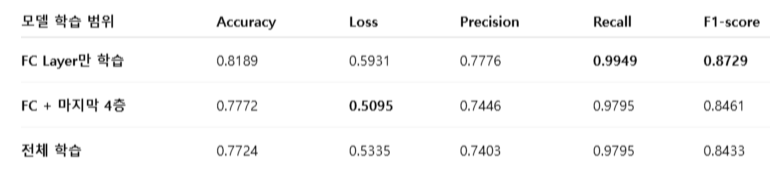

- FC Layer만 학습 했을때 Recall / Accuracy / F1-score가 가장 높았음

# 6. 결론 및 소감

- 이미지를 전처리 하는 과정에서 padding 과 resize , custom crop을 사용했으나 이미지 마다 특징이 다 달라서 폐부분만을 공통으로 가져오는 crop을
만들기 힘들었고 결론적으로 U-net을 이용한 image segmentaion을 통해 폐 이미지를 따로 추출해서 저장하고 이 이미지를 모델 학습에 사용했다면
더 좋은 결과를 만들수 있었을거라 생각합니다


### **input image size별 실험**

- 모든 모델에 대해 훈련 손실은 꾸준히 감소했고, 훈련 Accuracy/F1은 epoch 진행에 따라 90% 이상까지 상승했습니다.  각 모델 훈련 종료 후 테스트 세트 성능은 아래와 같습니다:


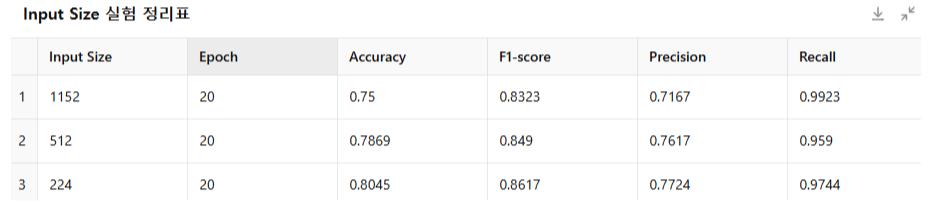



- 각 모델의 Precision-Recall 상호 관계를 살펴보면, 입력 이미지가 클수록 (1152 모델) Recall은 매우 높아 거의 모든 폐렴을 놓치지 않았지만, Precision은 낮아 정상도 폐렴으로 잘못 예측한 경우가 많았습니다

- 반대로 이미지 크기를 축소할수록 (512, 224 모델) Recall은 다소 낮아졌지만 Precision이 높아져 F1-score가 상승했습니다. 이는 불필요한 이미지 영역을 제거하고 입력 해상도를 낮춤으로써, 과적합을 줄이고 일반화 성능을 개선한 결과로 해석할 수 있습니다. 특히 1152 모델은 훈련 세트 Accuracy가 96% 이상까지 올라갔지만 테스트 Accuracy는 75%에 그쳐 심한 과적합이 나타났습니다
- 이에 비해 224 모델은 가장 높은 테스트 F1을 보였으며, 훈련 시간도 크게 단축되어 효율적이었습니다.


### **이미지 resize + custom Crop vs resize**

- 이미지 전처리에서 Custom Crop을 적용한 모델들은, 리사이즈만 적용한 모델에 비해 Recall 측면에서 우위를 보였습니다. 예를 들어, 별도의 크롭 없이 224로 리사이즈만 한 경우 Precision은 0.9144로 높았지만 Recall이 0.7667로 급격히 떨어져 F1=0.8340에 그쳤습니다
. 반면 Custom Crop을 적용한 224 모델은 Recall=0.9744로 매우 높고 F1=0.8617로 향상되었으나, Precision은 0.7724로 낮아 과잉 탐지(False Positive) 경향이 나타났습니다
. 따라서 리사이즈+크롭 전처리는 폐렴 검출에서 민감도(Recall)를 높이지만 정밀도(Precision)는 떨어뜨리는 효과가 있었습니다. 전체적으로 이미지 크기를 줄이고 불필요한 배경을 제거한 것이 모델의 일반화 성능 향상에 도움이 되었음을 확인했습니다.


### **사전학습 ResNet-18을 활용한 Fine-Tuning**

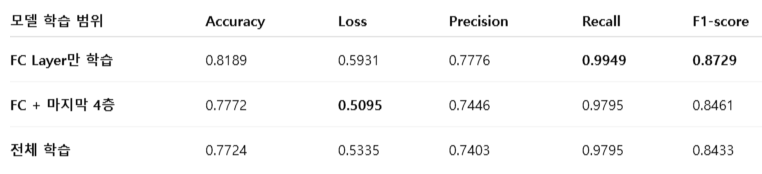

- 전체 학습보다는 FC Layer만 학습하거나, FC + 일부 레이어만 미세조정하는 방식이 더 효과적이었습니다.

### **ResNet-50 기반 성능 최적화 (Dropout, 클래스 불균형 보정, Augmentation, Threshold 튜닝)**

실험 목표: 앞선 실험에서 Recall은 매우 높지만 Precision이 낮아 F1-score ~0.84-0.86 수준에 머물렀습니다. 실험 3에서는 더 깊은 모델인 ResNet-50을 사용하고, 정규화 및 불균형 대응 기법을 적용하여 Precision을 끌어올리고 종합 성능(F1)을 높이고자 했습니다. 주요 시도한 기법들은 다음과 같습니다:
- 모델 깊이 확장: ResNet-18보다 파라미터 수가 많은 ResNet-50을 활용 (사전학습 가중치 사용). 더욱 복잡한 특성을 학습시켜 미묘한 차이를 구분하도록 기대합니다.

- Dropout 추가: ResNet 기본 구조에는 Dropout이 없으므로, 최종 출력층 직전에 Dropout(30%)을 넣어 과적합을 줄였습니다.
- 클래스 불균형 보정: 데이터셋에서 폐렴 이미지가 정상 대비 약 3배 많아(model 학습 시 ‘폐렴’으로 치우친 예측을 보임). 손실 함수 BCEWithLogitsLoss에 pos_weight를 적용하여 양성 클래스(폐렴)의 손실 가중치를 조정했습니다 (normal:pneumonia 비율인 약 0.346 사용)

. 이를 통해 정상 이미지에 대한 예측 오류도 충분히 벌점을 주어 Precision을 높이고자 했습니다.
- 데이터 증강: 훈련 시 무작위 수평 뒤집기, ±5도 이내 회전을 추가하여 데이터 다양성을 높였습니다
- Threshold 튜닝: 분류 결정 임곗값을 기본 0.5가 아닌, 검증 세트에서 최적 F1이 되는 값으로 조정했습니다.
- Recall 위주 모델의 Precision을 높이는 간단하면서 효과적인 방법이었습니다
- test 데이터를 통한 확인에서 가장높은 Accuracy 및 F1-score를 얻을 수 있었습니다
- Epoch 1: [Train] Acc=0.9479 | Prec=0.9853 | Rec=0.9439 | F1=0.9642 || [Val] Acc=0.9808 | Prec=0.9983 | Rec=0.9758 | F1=0.9869  
[Best Threshold] F1: 0.9466 at threshold 0.78  
== Test 성능 (Threshold Tuned) ==  
Accuracy : 0.9310897435897436  
Precision: 0.9180722891566265  
Recall   : 0.9769230769230769  
F1-score : 0.9465838509316771  

### 멘토 의견
이번 과제는 전처리에 대한 세심한 고민과 Custom CNN과 ResNet18을 병행해 비교 실험하신 점이 정말 인상적이었습니다. 특히 이미지 크기에 맞춘 padding·crop, 직접 계산한 mean/std 정규화, 그리고 불균형 대응을 위한 weight 적용처럼 데이터의 특성을 잘 파악하고 그를 통해 실험을 설계하신 점이 좋은 부분이라고 생각합니다.

다만, 다양한 모델의 실험결과를 비교해서 보기가 어려워서 Custom vs. ResNet18의 주요 지표를 한 화면에 비교 시각화해 보시면 보고서가 훨씬 명료해질 거예요.

전반적으로 탄탄한 실험 설계가 돋보였습니다. 수고하셨습니다 😊
